# Non-Linear Regression => Gauss-Newton method

In [1]:
import numpy as np
data = np.array([
0,22.8,
2.3,22.8,
4.9,22.8,
9.1,20.6,
13.7,13.9,
18.3,11.7,
22.9,11.1,
27.2,11.1]).T


In [2]:
z=data[0::2]
T=data[1::2]
z, T

(array([ 0. ,  2.3,  4.9,  9.1, 13.7, 18.3, 22.9, 27.2]),
 array([22.8, 22.8, 22.8, 20.6, 13.9, 11.7, 11.1, 11.1]))

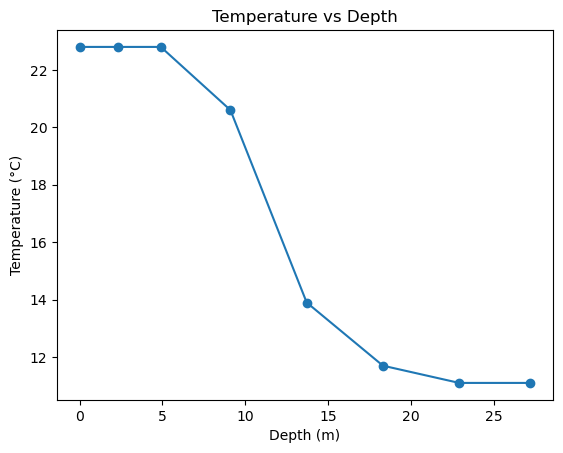

In [3]:
import matplotlib.pyplot as plt
plt.plot(z, T, 'o-')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Depth')
plt.show()

In [4]:
# Nonlinear cubic-like model using tanh envelope with a learnable depth shift.
# T(z) = d + a * tanh(b1*(z - z0) + b2*(z - z0)**2 + b3*(z - z0)**3)
def tanh_cubic_model(z, params):
    d, a, z0, b1, b2, b3 = params
    z_centered = z - z0
    poly = b1 * z_centered + b2 * z_centered**2 + b3 * z_centered**3
    return d + a * np.tanh(poly)


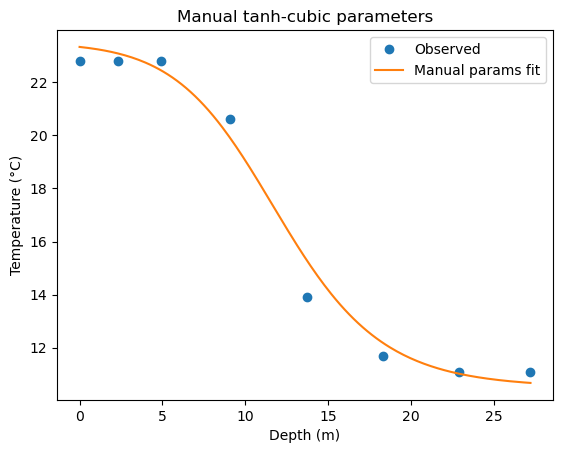

Manual parameters [d, a, b1, b2, b3]: [ 1.7e+01  6.5e+00  1.2e+01 -1.6e-01  1.5e-03 -2.0e-05]


In [5]:
# Manual parameter tweak for tanh-cubic model and plot
manual_params = np.array([
    17.0,    # d: baseline level
    6.5,     # a: amplitude (positive to give warm surface, cool deep)
    12.0,    # z0: center depth
    -0.16,   # b1
    0.0015,  # b2
    -2e-05,  # b3
], dtype=float)

z_plot = np.linspace(z.min(), z.max(), 200)
T_manual = tanh_cubic_model(z_plot, manual_params)

plt.figure()
plt.plot(z, T, 'o', label='Observed')
plt.plot(z_plot, T_manual, '-', label='Manual params fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Manual tanh-cubic parameters')
plt.legend()
plt.show()

print('Manual parameters [d, a, b1, b2, b3]:', manual_params)


In [8]:
import numpy as np

def preds_and_jacobian(params, z, T):
    d, a, z0, b1, b2, b3 = params
    zc = z - z0
    poly = b1*zc + b2*zc**2 + b3*zc**3

    t = np.tanh(poly)
    preds = d + a*t
    r = preds - T

    # derivative of tanh: sech^2 = 1 - tanh^2
    sech2 = 1.0 - t**2

    # sensitivities d(pred)/d(param) == d(r)/d(param)
    dr_dd  = np.ones_like(z)
    dr_da  = t
    dr_dz0 = a * sech2 * (-(b1 + 2*b2*zc + 3*b3*zc**2))
    dr_db1 = a * sech2 * zc
    dr_db2 = a * sech2 * zc**2
    dr_db3 = a * sech2 * zc**3

    # Assemble Jacobian J: N x 6
    J = np.column_stack([dr_dd, dr_da, dr_dz0, dr_db1, dr_db2, dr_db3])
    return preds, r, J

def loss_grad(params, z, T):
    preds, r, J = preds_and_jacobian(params, z, T)
    N = z.size
    loss = float(np.mean(r**2))
    grad = (2.0 / N) * (J.T @ r)
    return loss, grad, r, J


In [12]:
init_params=manual_params.copy()

In [13]:
def gauss_newton_fit(z, T, params, steps=30, damping=1e-1, clip_b=True):
    for step in range(steps):
        loss, grad, r, J = loss_grad(params, z, T)
        N = z.size

        # Gauss–Newton system: (J^T J) delta = - J^T r
        A = J.T @ J
        g = J.T @ r

        # Damping to improve stability (Levenberg-Marquardt flavor)
        A_damped = A + damping * np.eye(A.shape[0])

        delta = -np.linalg.solve(A_damped, g)

        params = params + delta

        if clip_b:
            params[3:] = np.clip(params[3:], -1.0, 1.0)

        if step % 5 == 0:
            print(f"GN step {step:3d}: loss={loss:.6e}, ||delta||={np.linalg.norm(delta):.3e}, params={params}")

    return params
final_params = gauss_newton_fit(z, T, init_params.copy(), steps=50)
init_params=final_params.copy()

GN step   0: loss=4.223022e-01, ||delta||=6.520e-01, params=[ 1.63577655e+01  6.41488571e+00  1.19998466e+01 -2.33511668e-01
  7.56487302e-03  6.97050425e-04]
GN step   5: loss=1.902327e-03, ||delta||=5.010e-02, params=[ 1.65033904e+01  6.32050886e+00  1.17040461e+01 -2.49433980e-01
  1.69103555e-02 -3.98078474e-04]
GN step  10: loss=1.750631e-03, ||delta||=1.557e-02, params=[ 1.65915432e+01  6.23327258e+00  1.16486368e+01 -2.55546414e-01
  1.62800953e-02 -3.61638856e-04]
GN step  15: loss=1.738294e-03, ||delta||=3.726e-03, params=[ 1.66151335e+01  6.20999265e+00  1.16341563e+01 -2.57201447e-01
  1.60839726e-02 -3.51307063e-04]
GN step  20: loss=1.737615e-03, ||delta||=8.299e-04, params=[ 1.66205399e+01  6.20466081e+00  1.16308527e+01 -2.57581916e-01
  1.60375874e-02 -3.48930246e-04]
GN step  25: loss=1.737581e-03, ||delta||=1.819e-04, params=[ 1.66217325e+01  6.20348480e+00  1.16301246e+01 -2.57665903e-01
  1.60272868e-02 -3.48405906e-04]
GN step  30: loss=1.737580e-03, ||delta||=3.97

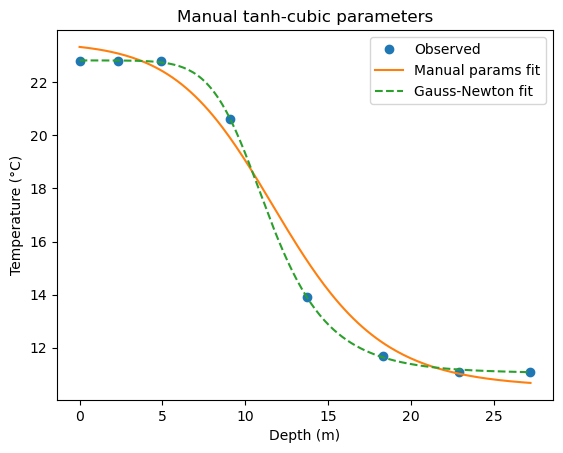

Manual parameters [d, a, b1, b2, b3]: [ 1.7e+01  6.5e+00  1.2e+01 -1.6e-01  1.5e-03 -2.0e-05]


In [14]:
z_plot = np.linspace(z.min(), z.max(), 200)
T_final = tanh_cubic_model(z_plot, final_params)

plt.figure()
plt.plot(z, T, 'o', label='Observed')
plt.plot(z_plot, T_manual, '-', label='Manual params fit')
plt.plot(z_plot, T_final, '--', label='Gauss-Newton fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Manual tanh-cubic parameters')
plt.legend()
plt.show()

print('Manual parameters [d, a, b1, b2, b3]:', manual_params)
